In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-26 22:44:18.570977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 22:44:19.940795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-26 20:14:27.175627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId",
           "DMesons_fitOutput__ImpactSignificance"]

to_add = ["DMesons_fitOutput__ImpactSignificance"]
print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [8]:
DMesons_df = generate_df(DMesonsTTree, branches, 2000000)
DMesons_df = apply_cuts(DMesons_df)

pd.set_option('display.max_rows', 10)
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411],"[[6.094892978668213, 1.3074619770050049, 2.733...","[(0.15998553, 0.011107716, -0.0614343)]","[(2.6128821, 2.7195172, 2.9228168)]","[(-321, 211, 211)]",[0.5543845891952515]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]","[[6.457057952880859, 5.970093250274658, 6.6375...","[(-1.608788, -1.6307458, -1.7315177), (-1.7326...","[(-0.371787, -0.5164238, -0.4971406), (-0.4966...","[(-321, 211, 211), (2212, -321, 211)]","[1.8095015287399292, 1.8095015287399292]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]","[[3.7944977283477783, 3.3083105087280273, 3.06...","[(-0.073717244, 0.22605924, -0.017923404), (0....","[(0.753864, 0.6827104, 0.920779), (0.6827104, ...","[(-321, 211, 211), (2212, -321, 211)]","[2.292919158935547, 2.292919158935547]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]","[[3.7815563678741455, 7.396467208862305, 1.412...","[(-0.9284433, -1.182188, -1.1012387), (-1.1821...","[(0.8518817, 0.7419038, 0.77916163), (0.741903...","[(-321, 211, 211), (2212, -321, 211)]","[0.7992758750915527, 0.7992758750915527]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122],"[[18.936317443847656, 15.39889907836914, 1.803...","[(0.69086045, 0.62282157, 0.63955635)]","[(0.857847, 0.81737196, 0.7582323)]","[(2212, -321, 211)]",[1.1388494968414307]
...,...,...,...,...,...,...,...,...,...,...,...
823353,[19.1050703125],[1.6708742380142212],[1802.5220947265625],[0.5411524176597595],[0.5503742098808289],[411],"[[12.198583602905273, 2.20495867729187, 4.7119...","[(1.705293, 1.5110217, 1.6457342)]","[(2.8939261, 2.7120652, 2.8616462)]","[(-321, 211, 211)]",[2.8667211532592773]
823354,"[35.5684921875, 35.5684921875]","[-1.688397765159607, -1.688397765159607]","[1844.779541015625, 2206.408203125]","[13.070379257202148, 13.070379257202148]","[-0.9140324592590332, -0.8278874754905701]","[411, 4122]","[[5.796909809112549, 20.56328582763672, 9.2475...","[(-1.6683935, -1.7061399, -1.6597538), (-1.706...","[(1.4682562, 1.4755678, 1.4053382), (1.4755678...","[(-321, 211, 211), (2212, -321, 211)]","[3.2546143531799316, 3.2546143531799316]"
823355,"[8.96414453125, 8.96414453125]","[-2.151238203048706, -2.151238203048706]","[1906.624267578125, 2233.773193359375]","[1.6992524862289429, 1.6992524862289429]","[0.1967991143465042, 0.495256245136261]","[411, 4122]","[[3.0222578048706055, 5.220008850097656, 0.736...","[(-2.0755956, -2.2418754, -1.6611706), (-2.241...","[(1.9180546, 1.8532572, 2.0587387), (1.8532572...","[(-321, 211, 211), (2212, -321, 211)]","[0.9604215025901794, 0.9604215025901794]"
823356,[17.66424609375],[-0.09207434207201004],[1886.3043212890625],[1.2944053411483765],[0.28153401613235474],[411],"[[9.11902904510498, 5.195584774017334, 3.37626...","[(-0.045325126, -0.065605104, -0.25413564)]","[(1.7839004, 1.9068127, 1.8262501)]","[(-321, 211, 211)]",[3.164067029953003]


In [9]:
Lambda_df = generate_df(LambdaMesonsTTree, branches, 2000000)
Lambda_df = apply_cuts(Lambda_df)

pd.set_option('display.max_rows', 10)
Lambda_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,"[15.8373623046875, 15.8373623046875]","[-1.9853405952453613, -1.9853405952453613]","[2277.830078125, 2369.549072265625]","[0.04267885163426399, 0.04267885163426399]","[-0.2451278269290924, -0.17632918059825897]","[4122, 4122]","[[6.491756916046143, 3.2679483890533447, 6.113...","[(-2.0230656, -2.0707278, -1.8890115), (-1.889...","[(-2.1058285, -2.2039685, -2.201573), (-2.2013...","[(2212, -321, 211), (2212, -321, 211)]","[2.5830554962158203, 2.5830554962158203]"
1,"[98.7876796875, 98.7876796875]","[-0.2930956184864044, -0.2930956184864044]","[1919.40869140625, 2260.435791015625]","[2.1269333362579346, 2.1269333362579346]","[0.06200433894991875, 0.3847692906856537]","[411, 4122]","[[29.078584671020508, 10.136245727539062, 59.8...","[(-0.28745878, -0.29004973, -0.29698882), (-0....","[(-2.6987991, -2.6463094, -2.698718), (-2.6987...","[(-321, 211, 211), (2212, -321, 211)]","[1.1140474081039429, 1.1140474081039429]"
2,[8.6058642578125],[0.07536902278661728],[2293.048583984375],[0.09962315112352371],[0.4434269666671753],[4122],"[[2.7384893894195557, 4.709741592407227, 1.240...","[(0.19276412, 0.01101852, 0.053698417)]","[(-2.1192122, -1.8384731, -2.1108038)]","[(2212, -321, 211)]",[4.643901348114014]
3,[11.53853515625],[0.2006414383649826],[2288.4326171875],[0.48169323801994324],[0.9700170755386353],[4122],"[[2.246781587600708, 7.883712291717529, 1.4038...","[(0.20760234, 0.22167633, 0.07100553)]","[(-2.8044589, -2.8241496, -2.8006365)]","[(2212, -321, 211)]",[2.421121120452881]
4,[29.4526484375],[0.05501718819141388],[2301.531494140625],[1.2502720355987549],[0.7273651361465454],[4122],"[[8.355555534362793, 18.87540626525879, 2.2310...","[(0.10226753, 0.028720934, 0.09831465)]","[(1.4927285, 1.5366541, 1.5769836)]","[(2212, -321, 211)]",[2.595268964767456]
...,...,...,...,...,...,...,...,...,...,...,...
712648,"[34.463046875, 34.463046875]","[0.31471043825149536, 0.31471043825149536]","[1740.138671875, 2299.086181640625]","[1.5627269744873047, 1.5627269744873047]","[0.1562846302986145, 0.4890439212322235]","[411, 4122]","[[15.651188850402832, 5.544079780578613, 13.24...","[(0.3235349, 0.37399396, 0.2787361), (0.278787...","[(0.4758191, 0.5486185, 0.5259811), (0.5257968...","[(-321, 211, 211), (2212, -321, 211)]","[1.347546935081482, 1.347546935081482]"
712649,[21.214580078125],[-1.1575630903244019],[2294.565673828125],[0.4024292826652527],[-0.8603967428207397],[4122],"[[14.745858192443848, 2.744957447052002, 3.758...","[(-1.1659735, -1.0675877, -1.1798809)]","[(2.3274233, 2.2858722, 2.182565)]","[(2212, -321, 211)]",[4.43757963180542]
712650,[78.9265390625],[0.9490858316421509],[2278.0],[3.1103579998016357],[-0.23155681788921356],[4122],"[[22.820960998535156, 17.21006965637207, 38.08...","[(0.95355487, 0.96059924, 0.9411635)]","[(0.8717007, 0.89668804, 0.8914601)]","[(2212, -321, 211)]",[3.1761653423309326]
712651,"[8.3078798828125, 8.3078798828125]","[1.7236647605895996, 1.7236647605895996]","[2279.513427734375, 2440.34130859375]","[0.27863630652427673, 0.27863630652427673]","[-0.4692881405353546, -0.40096166729927063]","[4122, 4122]","[[4.055630683898926, 1.4534549713134766, 2.834...","[(1.6344042, 2.0164008, 1.6586056), (1.6573379...","[(-1.7249979, -1.4534848, -1.7085202), (-1.708...","[(2212, -321, 211), (2212, -321, 211)]","[0.8141367435455322, 0.8141367435455322]"


In [10]:
DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 81475 duplicate particles
Removed 34651 duplicate particles


In [11]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [51]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [52]:
DMesons_df = DMesons_df.head(500000)
Lambda_df = Lambda_df.head(500000)

In [53]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        impacts = row['DMesons_costhetastar']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds, 
             
             df.columns[10]: impacts}
        
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [54]:
DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [4]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

# DMesons_df = load("DMesons_df_separated")
# Lambda_df = load("Lambda_df_separated")

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")

len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [11]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [55]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

#new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [56]:
save(only_4122, "DMesons_only_4122")

In [57]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

# new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [58]:
save(only_4122, "Lambda_only_4122")

In [60]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("DMesons_only_4122")

In [61]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})

DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,411,"[6.605627059936523, 6.457057952880859, 5.96782...","(-1.7326077, -1.608788, -1.6305238)","(-0.49662885, -0.371787, -0.5161313)","(2212, -321, 211)",-0.065073,only_4122
4,10.118494,0.041659,2468.180664,2.890126,0.427697,411,"[3.3083105087280273, 3.7944977283477783, 3.065...","(0.22605924, -0.073717244, -0.017923404)","(0.6827104, 0.753864, 0.920779)","(2212, -321, 211)",0.427697,only_4122
6,12.579471,-1.102560,2220.384521,0.924919,-0.413329,411,"[7.396467208862305, 3.7815563678741455, 1.4123...","(-1.182188, -0.9284433, -1.1012387)","(0.7419038, 0.8518817, 0.77916163)","(2212, -321, 211)",-0.413329,only_4122
7,36.128836,0.659816,2235.698730,0.358412,0.190362,411,"[18.936317443847656, 15.39889907836914, 1.8038...","(0.69086045, 0.62282157, 0.63955635)","(0.857847, 0.81737196, 0.7582323)","(2212, -321, 211)",0.190362,only_4122
9,15.020291,-0.034316,2239.309326,1.028398,0.067321,411,"[8.733827590942383, 4.532932281494141, 1.78765...","(0.01380682, -0.04224944, -0.24547637)","(2.2951803, 2.1494887, 2.202617)","(2212, -321, 211)",0.067321,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
829417,18.804258,0.885162,2189.650146,7.739953,-0.889773,411,"[12.417222023010254, 2.854801654815674, 3.5459...","(0.9136081, 0.91393214, 0.7531416)","(1.6027179, 1.6470815, 1.6886618)","(2212, -321, 211)",-0.889773,only_4122
829419,17.901893,-0.774406,2254.505371,5.573455,0.345450,411,"[10.548990249633789, 4.042133808135986, 3.3070...","(-0.71441394, -0.78476083, -0.939658)","(1.8309624, 1.8176006, 1.7980983)","(2212, -321, 211)",0.345450,only_4122
829421,13.787465,0.994835,2403.642334,9.813573,0.585470,411,"[5.433959007263184, 5.768528938293457, 2.64782...","(0.9409741, 0.9637201, 1.1431166)","(1.0212605, 0.8464486, 0.807192)","(2212, -321, 211)",0.585470,only_4122
829423,21.512328,-0.477626,2418.774170,1.613223,0.734164,411,"[8.097429275512695, 9.11487102508545, 4.309597...","(-0.40710476, -0.47758043, -0.60352147)","(0.27852488, 0.3333423, 0.26191172)","(2212, -321, 211)",0.734164,only_4122


In [62]:
# Lambda_only_4122 = Lambda_only_4122.head(400000)
# DMesons_only_411 = DMesons_only_411.head(400000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [63]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
0,12.443068,0.470365,2293.060791,0.307268,-0.683081,4122,"[9.774184226989746, 2.1095800399780273, 0.6343...","(0.46994826, 0.3994005, 0.6516006)","(2.932724, 2.647051, 2.7397742)","(2212, -321, 211)",-0.683081,only_4122
1,26.705480,1.520493,2408.571777,0.306569,-0.695930,411,"[9.764349937438965, 4.176248073577881, 12.8585...","(1.5251796, 1.4776238, 1.5285559)","(1.2295191, 1.0925354, 1.2039886)","(2212, -321, 211)",-0.695930,only_4122
2,13.269726,-0.608384,2427.839600,0.455515,0.502413,411,"[5.087174415588379, 7.396163463592529, 0.88932...","(-0.6033195, -0.61551744, -0.5126167)","(0.108974874, 0.2786502, -0.17014179)","(2212, -321, 211)",0.502413,only_4122
3,15.824381,-0.606808,2299.451172,0.302876,-0.018135,4122,"[7.0710883140563965, 5.710262775421143, 3.1065...","(-0.54863507, -0.65513754, -0.63635236)","(-1.7401855, -1.8990229, -1.6892179)","(2212, -321, 211)",-0.018135,only_4122
4,17.319188,-0.954492,2295.337158,1.534582,0.691555,4122,"[8.148868560791016, 6.373940944671631, 2.80117...","(-1.0312663, -0.9255963, -0.7765741)","(-2.0952804, -2.1495998, -2.1521118)","(2212, -321, 211)",0.691555,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
999808,20.867049,1.698555,2212.154785,0.320814,0.255238,4122,"[5.455611228942871, 6.063255310058594, 9.37191...","(1.7370666, 1.6639266, 1.6967529)","(-1.8600731, -1.7853712, -1.7932432)","(2212, -321, 211)",0.255238,only_4122
999809,12.284048,-0.557109,2233.189209,9.396533,0.117401,411,"[7.319913387298584, 3.8884575366973877, 1.1284...","(-0.55717754, -0.4703416, -0.80634415)","(1.7364426, 1.8575523, 2.0372558)","(2212, -321, 211)",0.117401,only_4122
999810,21.641627,-1.919908,2257.242188,1.045481,-0.132554,4122,"[8.697320938110352, 5.228368759155273, 7.73267...","(-1.8586911, -1.9589291, -1.9576769)","(-0.15766475, -0.10408575, -0.20097777)","(2212, -321, 211)",-0.132554,only_4122
999811,13.990378,-0.222744,2300.662598,0.281639,-0.406515,4122,"[9.497482299804688, 3.4336376190185547, 1.1495...","(-0.24122292, -0.1987707, -0.1238882)","(-0.26351026, -0.05162505, -0.45902085)","(2212, -321, 211)",-0.406515,only_4122


In [64]:
shuffled_df["DMesons_daughterInfo__eta"] = shuffled_df["DMesons_daughterInfo__eta"].apply(list)
shuffled_df["DMesons_daughterInfo__phi"] = shuffled_df["DMesons_daughterInfo__phi"].apply(list)

In [ ]:
#shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [66]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(eta)
        daughter_phis.append(phi)

In [67]:
#particle1 is proton, or pion in D+ hyp
#particle2 is kaon
#particle3 is pion

particle1_pt = []
particle2_pt = []
particle3_pt = []

particle1_eta = []
particle2_eta = []
particle3_eta = []

particle1_phi = []
particle2_phi = []
particle3_phi = []

for i in range(0, len(daughter_pts), 3):
    #daughter_pt
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])
    
    #daughter_eta
    particle1_eta.append(daughter_etas[i])
    particle2_eta.append(daughter_etas[i+1])
    particle3_eta.append(daughter_etas[i+2])
    
    #daughter_phi
    particle1_phi.append(daughter_phis[i])
    particle2_phi.append(daughter_phis[i+1])
    particle3_phi.append(daughter_phis[i+2])

In [107]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #D+ Hypothesis: assume proton is pion for 
                #Lambda Hypothesis: keep proton as proton
                return p_mass
            else:
                raise Exception("Are there more particle types?")
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [108]:
LorentzVectors = createTLorentzVectors(shuffled_df)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

(999813, 3)

In [109]:
pk_list = []
kpi_list = []

ppi_list = []
pipi_list = []

pipi_list1 = []
pipi_list2 = []

#find the ordering of the Loretnz Vectors

#Lambda Hypothesis
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for i in LorentzVectors:
    if round(i.M(), 3) == p_mass:
        p_LorentzVectors.append(i)
    elif round(i.M(), 6) == k_mass:
        k_LorentzVectors.append(i)
    elif round(i.M(), 4) == 0.1396:
        pi_LorentzVectors.append(i)

#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

In [110]:
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)

In [113]:
#Lambda
for i in range(len(p_LorentzVectors)):
    ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
    ppi_list.append(ppi)

In [87]:
#D
for i in range(len(p_LorentzVectors)):
    pipi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
    pipi_list.append(pipi)

In [114]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi


# shuffled_df['inv_mass7'] = pk_list
# shuffled_df['inv_mass8'] = kpi_list
shuffled_df['inv_mass9'] = ppi_list

In [115]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,...,particle_type,inv_mass1,inv_mass2,inv_mass3,inv_mass4,inv_mass5,inv_mass6,inv_mass7,inv_mass8,inv_mass9
0,12.443068,0.470365,2293.060791,0.307268,-0.683081,4122,"[9.774184226989746, 2.1095800399780273, 0.6343...","[0.46994826, 0.3994005, 0.6516006]","[2.932724, 2.647051, 2.7397742]","(2212, -321, 211)",...,only_4122,3.190309,0.500279,0.747154,1.909845,0.199670,0.747154,4.234916,0.500279,1.669615
1,26.705480,1.520493,2408.571777,0.306569,-0.695930,411,"[9.764349937438965, 4.176248073577881, 12.8585...","[1.5251796, 1.4776238, 1.5285559]","[1.2295191, 1.0925354, 1.2039886]","(2212, -321, 211)",...,only_4122,1.721925,1.860250,0.162703,0.950718,0.913506,0.162703,2.935083,1.860250,2.159103
2,13.269726,-0.608384,2427.839600,0.455515,0.502413,411,"[5.087174415588379, 7.396163463592529, 0.88932...","[-0.6033195, -0.61551744, -0.5126167]","[0.108974874, 0.2786502, -0.17014179]","(2212, -321, 211)",...,only_4122,1.544373,1.833622,0.545777,1.167010,1.583581,0.545777,3.658215,1.833622,1.550284
3,15.824381,-0.606808,2299.451172,0.302876,-0.018135,4122,"[7.0710883140563965, 5.710262775421143, 3.1065...","[-0.54863507, -0.65513754, -0.63635236]","[-1.7401855, -1.8990229, -1.6892179]","(2212, -321, 211)",...,only_4122,2.039524,1.214726,0.316414,1.553390,0.869874,0.316414,3.635016,1.214726,1.571744
4,17.319188,-0.954492,2295.337158,1.534582,0.691555,4122,"[8.148868560791016, 6.373940944671631, 2.80117...","[-1.0312663, -0.9255963, -0.7765741]","[-2.0952804, -2.1495998, -2.1521118]","(2212, -321, 211)",...,only_4122,1.348141,0.806294,1.674963,0.813728,0.493157,1.674963,2.830091,0.806294,2.781599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999808,20.867049,1.698555,2212.154785,0.320814,0.255238,4122,"[5.455611228942871, 6.063255310058594, 9.37191...","[1.7370666, 1.6639266, 1.6967529]","[-1.8600731, -1.7853712, -1.7932432]","(2212, -321, 211)",...,only_4122,0.879730,0.728523,0.394336,0.439485,0.146987,0.394336,2.632664,0.728523,2.676629
999809,12.284048,-0.557109,2233.189209,9.396533,0.117401,411,"[7.319913387298584, 3.8884575366973877, 1.1284...","[-0.55717754, -0.4703416, -0.80634415]","[1.7364426, 1.8575523, 2.0372558]","(2212, -321, 211)",...,only_4122,1.381395,1.045535,1.408606,0.718829,0.742689,1.408606,2.681897,1.045535,2.422808
999810,21.641627,-1.919908,2257.242188,1.045481,-0.132554,4122,"[8.697320938110352, 5.228368759155273, 7.73267...","[-1.8586911, -1.9589291, -1.9576769]","[-0.15766475, -0.10408575, -0.20097777]","(2212, -321, 211)",...,only_4122,1.232152,1.015666,0.863580,0.669075,0.460241,0.863580,2.661826,1.015666,2.564656
999811,13.990378,-0.222744,2300.662598,0.281639,-0.406515,4122,"[9.497482299804688, 3.4336376190185547, 1.1495...","[-0.24122292, -0.1987707, -0.1238882]","[-0.26351026, -0.05162505, -0.45902085]","(2212, -321, 211)",...,only_4122,2.464633,1.070893,0.771541,1.617689,0.772341,0.771541,3.635519,1.070893,1.734354


In [116]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df["daughter_eta1"] = particle1_eta
invmass_ready_df["daughter_eta2"] = particle2_eta
invmass_ready_df["daughter_eta3"] = particle3_eta
invmass_ready_df["daughter_phi1"] = particle1_phi
invmass_ready_df["daughter_phi2"] = particle2_phi
invmass_ready_df["daughter_phi3"] = particle3_phi
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,12.443068,0.470365,2293.060791,0.307268,-0.683081,4122,-0.683081,3.190309,0.500279,0.747154,...,1.669615,9.774184,2.109580,0.634305,0.469948,0.399401,0.651601,2.932724,2.647051,2.739774
1,26.705480,1.520493,2408.571777,0.306569,-0.695930,411,-0.695930,1.721925,1.860250,0.162703,...,2.159103,9.764350,4.176248,12.858527,1.525180,1.477624,1.528556,1.229519,1.092535,1.203989
2,13.269726,-0.608384,2427.839600,0.455515,0.502413,411,0.502413,1.544373,1.833622,0.545777,...,1.550284,5.087174,7.396163,0.889324,-0.603320,-0.615517,-0.512617,0.108975,0.278650,-0.170142
3,15.824381,-0.606808,2299.451172,0.302876,-0.018135,4122,-0.018135,2.039524,1.214726,0.316414,...,1.571744,7.071088,5.710263,3.106538,-0.548635,-0.655138,-0.636352,-1.740185,-1.899023,-1.689218
4,17.319188,-0.954492,2295.337158,1.534582,0.691555,4122,0.691555,1.348141,0.806294,1.674963,...,2.781599,8.148869,6.373941,2.801176,-1.031266,-0.925596,-0.776574,-2.095280,-2.149600,-2.152112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999808,20.867049,1.698555,2212.154785,0.320814,0.255238,4122,0.255238,0.879730,0.728523,0.394336,...,2.676629,5.455611,6.063255,9.371914,1.737067,1.663927,1.696753,-1.860073,-1.785371,-1.793243
999809,12.284048,-0.557109,2233.189209,9.396533,0.117401,411,0.117401,1.381395,1.045535,1.408606,...,2.422808,7.319913,3.888458,1.128454,-0.557178,-0.470342,-0.806344,1.736443,1.857552,2.037256
999810,21.641627,-1.919908,2257.242188,1.045481,-0.132554,4122,-0.132554,1.232152,1.015666,0.863580,...,2.564656,8.697321,5.228369,7.732677,-1.858691,-1.958929,-1.957677,-0.157665,-0.104086,-0.200978
999811,13.990378,-0.222744,2300.662598,0.281639,-0.406515,4122,-0.406515,2.464633,1.070893,0.771541,...,1.734354,9.497482,3.433638,1.149503,-0.241223,-0.198771,-0.123888,-0.263510,-0.051625,-0.459021


In [117]:
save(invmass_ready_df, "invmass9_ready_df")

In [118]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [119]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

new_df = new_df.drop('DMesons_m', axis=1)
only_411 = only_411.drop('DMesons_m', axis=1)
only_4122 = only_4122.drop('DMesons_m', axis=1)

In [120]:
new_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,12.443068,0.470365,0.307268,-0.683081,4122,-0.683081,3.190309,0.500279,0.747154,1.909845,...,1.669615,9.774184,2.109580,0.634305,0.469948,0.399401,0.651601,2.932724,2.647051,2.739774
1,26.705480,1.520493,0.306569,-0.695930,411,-0.695930,1.721925,1.860250,0.162703,0.950718,...,2.159103,9.764350,4.176248,12.858527,1.525180,1.477624,1.528556,1.229519,1.092535,1.203989
2,13.269726,-0.608384,0.455515,0.502413,411,0.502413,1.544373,1.833622,0.545777,1.167010,...,1.550284,5.087174,7.396163,0.889324,-0.603320,-0.615517,-0.512617,0.108975,0.278650,-0.170142
3,15.824381,-0.606808,0.302876,-0.018135,4122,-0.018135,2.039524,1.214726,0.316414,1.553390,...,1.571744,7.071088,5.710263,3.106538,-0.548635,-0.655138,-0.636352,-1.740185,-1.899023,-1.689218
4,17.319188,-0.954492,1.534582,0.691555,4122,0.691555,1.348141,0.806294,1.674963,0.813728,...,2.781599,8.148869,6.373941,2.801176,-1.031266,-0.925596,-0.776574,-2.095280,-2.149600,-2.152112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999808,20.867049,1.698555,0.320814,0.255238,4122,0.255238,0.879730,0.728523,0.394336,0.439485,...,2.676629,5.455611,6.063255,9.371914,1.737067,1.663927,1.696753,-1.860073,-1.785371,-1.793243
999809,12.284048,-0.557109,9.396533,0.117401,411,0.117401,1.381395,1.045535,1.408606,0.718829,...,2.422808,7.319913,3.888458,1.128454,-0.557178,-0.470342,-0.806344,1.736443,1.857552,2.037256
999810,21.641627,-1.919908,1.045481,-0.132554,4122,-0.132554,1.232152,1.015666,0.863580,0.669075,...,2.564656,8.697321,5.228369,7.732677,-1.858691,-1.958929,-1.957677,-0.157665,-0.104086,-0.200978
999811,13.990378,-0.222744,0.281639,-0.406515,4122,-0.406515,2.464633,1.070893,0.771541,1.617689,...,1.734354,9.497482,3.433638,1.149503,-0.241223,-0.198771,-0.123888,-0.263510,-0.051625,-0.459021


In [121]:
save(new_df, "new_df_invmassdaughter_train")
save(only_411, "only_411_invmassdaughter_train")
save(only_4122, "only_4122_invmassdaughter_train")

In [3]:
new_df = load("new_df_invmassdaughter_train")
only_411 = load("only_411_invmassdaughter_train")
only_4122 = load("only_4122_invmassdaughter_train")

In [122]:
training_columns = get_columns(new_df)
training_columns.remove('DMesons_pdgId')
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [52]:
#(X_train1[column], X[train2], title, xlabel)

# data_list = [(X_train1["inv_mass1"], X_train2["inv_mass1"], "Histogram of $m^2(pK^{-})$ ($D^{+}$ Hypothesis)", "$m^2(pK^{-}) [GeV^{2}]$"),
#              (X_train1["inv_mass2"], X_train2["inv_mass2"], "Histogram of $m^2(k^{-}\pi^{+})$ ($D^{+}$ Hypothesis)", "$m^2 k^{-}\pi [GeV]^2$"),
#              (X_train1["inv_mass3"], X_train2["inv_mass3"], "Histogram of $m^2(pK^{-})$ ($\Lambda_C{+}$ Hypothesis)", "$m^2(pK^{-}) [GeV^{2}]$"),
#              (X_train1["inv_mass4"], X_train2["inv_mass4"], "Histogram of $m^2(k^{-}\pi^{+})$ ($\Lambda_C^{+}$ Hypothesis)", "$m^2 k^{-}\pi [GeV]^2$"),
#              (X_train1["DMesons_pt"], X_train2["DMesons_pt"], "Signal vs Backround P_t (Normalized)", "Transverse Momentum (p_t) [MeV]"),
#              (X_train1["DMesons_fitOutput__Lxy"], X_train2["DMesons_fitOutput__Lxy"], "Signal vs Backround $L_{xy}$ (Normalized)", "Decay Length (L_xy) [mm]"),
#              (X_train1["DMesons_costhetastar"], X_train2["DMesons_costhetastar"], "Signal vs Backround cosθ* (Normalized)", "Cosine of Helicity Angle (cosθ*)"),
#              (X_train1["DMesons_fitOutput__ImpactSignificance"], X_train2["DMesons_fitOutput__ImpactSignificance"], "Signal vs Backround DMesons ImpactSignificance (Normalized)", "DMesons_fitOutput__ImpactSignificance")
#             ]

# def plot_normalized_histograms(data_list, bins):
#     for data1, data2, title, xlabel in data_list:
#         hist_normalized(data1, data2, bins)
#         plt.title(title)
#         plt.xlabel(xlabel)
#         plt.ylabel("Normalized Counts")
#         plt.legend()
#         plt.show()

# plot_normalized_histograms(data_list, 100)

In [54]:
# hist_normalized(X_train1["DMesons_fitOutput__Lxy"], X_train2["DMesons_fitOutput__Lxy"], 1000)
# plt.title("Signal vs Backround $L_{xy}$ (Normalized)")
# plt.xlabel("Decay Length (L_xy) [mm]")
# plt.xlim(0, 25)
# plt.ylabel("Normalized Counts")
# plt.legend()
# plt.show()

# hist_normalized(X_train1["daughter_eta2"], X_train2["daughter_eta2"], 100)
# plt.title("Signal vs Backround Daughter eta (Normalized)")
# plt.xlabel("(phi)")
# plt.ylabel("Normalized Counts")
# plt.legend()
# plt.show()

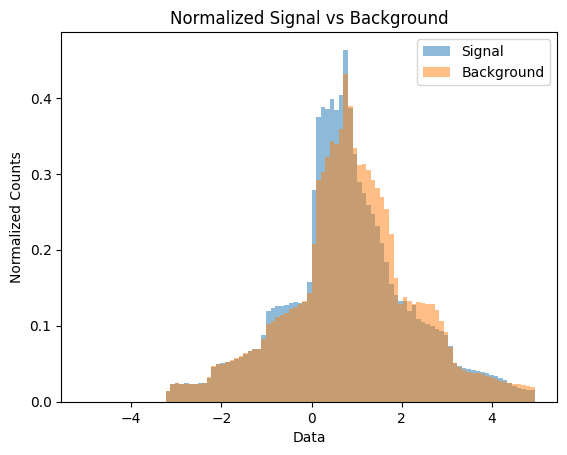

In [123]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 100)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [124]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 128,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 64,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 25,
        "batch_size": 32
    }
)
config = wandb.config

In [125]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  3072      
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  8256      
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  65        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


In [126]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

Epoch 1/25
24993/24996 [============================>.] - ETA: 0s - loss: 0.3666 - custom_accuracy: 0.8387

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 50s 2ms/step - loss: 0.3666 - custom_accuracy: 0.8387 - val_loss: 0.2980 - val_custom_accuracy: 0.8724
Epoch 2/25
24979/24996 [============================>.] - ETA: 0s - loss: 0.3138 - custom_accuracy: 0.8632

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 49s 2ms/step - loss: 0.3138 - custom_accuracy: 0.8632 - val_loss: 0.2600 - val_custom_accuracy: 0.8884
Epoch 3/25
24974/24996 [============================>.] - ETA: 0s - loss: 0.2887 - custom_accuracy: 0.8754

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 49s 2ms/step - loss: 0.2887 - custom_accuracy: 0.8754 - val_loss: 0.2332 - val_custom_accuracy: 0.9042
Epoch 4/25
24987/24996 [============================>.] - ETA: 0s - loss: 0.2748 - custom_accuracy: 0.8839

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 49s 2ms/step - loss: 0.2748 - custom_accuracy: 0.8839 - val_loss: 0.2267 - val_custom_accuracy: 0.9003
Epoch 5/25
24970/24996 [============================>.] - ETA: 0s - loss: 0.2658 - custom_accuracy: 0.8887

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 51s 2ms/step - loss: 0.2658 - custom_accuracy: 0.8887 - val_loss: 0.2185 - val_custom_accuracy: 0.9102
Epoch 6/25
24996/24996 [==============================] - 47s 2ms/step - loss: 0.2589 - custom_accuracy: 0.8920 - val_loss: 0.2217 - val_custom_accuracy: 0.9103
Epoch 7/25
24983/24996 [============================>.] - ETA: 0s - loss: 0.2535 - custom_accuracy: 0.8949

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 49s 2ms/step - loss: 0.2535 - custom_accuracy: 0.8949 - val_loss: 0.2096 - val_custom_accuracy: 0.9102
Epoch 8/25
24965/24996 [============================>.] - ETA: 0s - loss: 0.2500 - custom_accuracy: 0.8969

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 49s 2ms/step - loss: 0.2500 - custom_accuracy: 0.8970 - val_loss: 0.2083 - val_custom_accuracy: 0.9116
Epoch 9/25
24996/24996 [==============================] - 48s 2ms/step - loss: 0.2461 - custom_accuracy: 0.8990 - val_loss: 0.2146 - val_custom_accuracy: 0.9108
Epoch 10/25
24989/24996 [============================>.] - ETA: 0s - loss: 0.2437 - custom_accuracy: 0.8998

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 48s 2ms/step - loss: 0.2437 - custom_accuracy: 0.8998 - val_loss: 0.2045 - val_custom_accuracy: 0.9133
Epoch 11/25
24996/24996 [==============================] - ETA: 0s - loss: 0.2403 - custom_accuracy: 0.9016

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 48s 2ms/step - loss: 0.2403 - custom_accuracy: 0.9016 - val_loss: 0.2018 - val_custom_accuracy: 0.9192
Epoch 12/25
24967/24996 [============================>.] - ETA: 0s - loss: 0.2385 - custom_accuracy: 0.9029

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 48s 2ms/step - loss: 0.2385 - custom_accuracy: 0.9029 - val_loss: 0.1981 - val_custom_accuracy: 0.9214
Epoch 13/25
24996/24996 [==============================] - 48s 2ms/step - loss: 0.2363 - custom_accuracy: 0.9035 - val_loss: 0.2021 - val_custom_accuracy: 0.9170
Epoch 14/25
24996/24996 [==============================] - 48s 2ms/step - loss: 0.2347 - custom_accuracy: 0.9049 - val_loss: 0.1982 - val_custom_accuracy: 0.9181
Epoch 15/25
24970/24996 [============================>.] - ETA: 0s - loss: 0.2331 - custom_accuracy: 0.9056

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 49s 2ms/step - loss: 0.2331 - custom_accuracy: 0.9056 - val_loss: 0.1913 - val_custom_accuracy: 0.9236
Epoch 16/25
24996/24996 [==============================] - 48s 2ms/step - loss: 0.2319 - custom_accuracy: 0.9064 - val_loss: 0.1928 - val_custom_accuracy: 0.9214
Epoch 17/25
24986/24996 [============================>.] - ETA: 0s - loss: 0.2304 - custom_accuracy: 0.9070

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230427_015353-3bg8q0pr/files/model-best)... Done. 0.0s


24996/24996 [==============================] - 48s 2ms/step - loss: 0.2304 - custom_accuracy: 0.9070 - val_loss: 0.1911 - val_custom_accuracy: 0.9240
Epoch 18/25
24996/24996 [==============================] - 48s 2ms/step - loss: 0.2294 - custom_accuracy: 0.9073 - val_loss: 0.1975 - val_custom_accuracy: 0.9156
Epoch 19/25
24996/24996 [==============================] - 47s 2ms/step - loss: 0.2280 - custom_accuracy: 0.9078 - val_loss: 0.1938 - val_custom_accuracy: 0.9203
Epoch 20/25
24996/24996 [==============================] - 47s 2ms/step - loss: 0.2266 - custom_accuracy: 0.9091 - val_loss: 0.1962 - val_custom_accuracy: 0.9191
Epoch 20: early stopping
6249/6249 [==============================] - 7s 1ms/step - loss: 0.1962 - custom_accuracy: 0.9191
Loss: [0.1962301880121231, 0.9191442728042603]
Training runtime: 976.2849655151367 seconds


2023-04-27 01:55:01.991114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-27 01:55:02.010876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-27 01:55:02.196775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-27 01:55:

In [127]:
wandb.finish()

custom_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇███████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_custom_accuracy,▁▃▅▅▆▆▆▆▆▇▇█▇▇███▇▇▇
val_loss,█▆▄▃▃▃▂▂▃▂▂▁▂▁▁▁▁▁▁▁
best_epoch,16
best_val_loss,0.19109
custom_accuracy,0.90912
epoch,19
loss,0.22664
val_custom_accuracy,0.91914


------------------------------------------ Finished training, now analyze ------------------------------------------

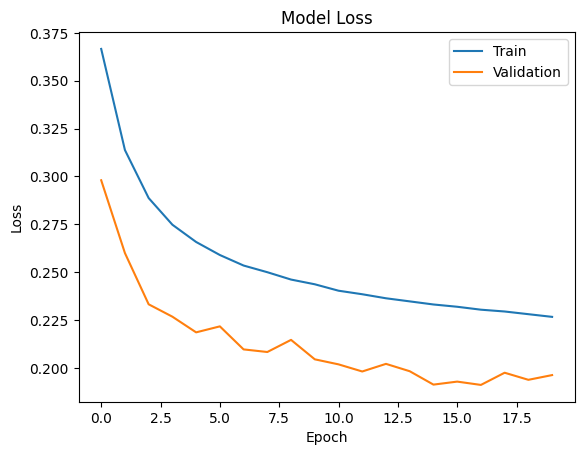

In [128]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [129]:
predictions_both = model.predict(X_test)
predictions_both[:10]

6249/6249 [==============================] - 6s 1ms/step


array([[9.4578063e-01],
       [1.4034148e-01],
       [6.2528944e-01],
       [9.3481374e-01],
       [3.5706023e-03],
       [1.4249501e-06],
       [1.5786235e-03],
       [9.8977315e-01],
       [3.8275186e-03],
       [9.9736202e-01]], dtype=float32)

In [130]:
predictions_background = model.predict(X_test1)
predictions_background[:10]

2535/2535 [==============================] - 3s 1ms/step


array([[2.9530966e-01],
       [5.8354284e-03],
       [1.5435782e-05],
       [4.9830794e-01],
       [2.4530446e-02],
       [6.3409150e-02],
       [2.6316529e-03],
       [1.2800132e-02],
       [3.7267932e-03],
       [3.1473544e-01]], dtype=float32)

In [131]:
predictions_signal = model.predict(X_test2)
predictions_signal[:10]

3714/3714 [==============================] - 4s 1ms/step


array([[0.99654603],
       [0.9363425 ],
       [0.99987006],
       [0.99978083],
       [0.9854122 ],
       [0.99911195],
       [0.9992982 ],
       [0.9934765 ],
       [0.7564554 ],
       [0.99990106]], dtype=float32)

In [132]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both))
accuracy_background = pred_accuracy(y_test1, list(predictions_background))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 91.91%
Accuracy for Only Background: 85.11%
Accuracy for Only Signal: 96.78%


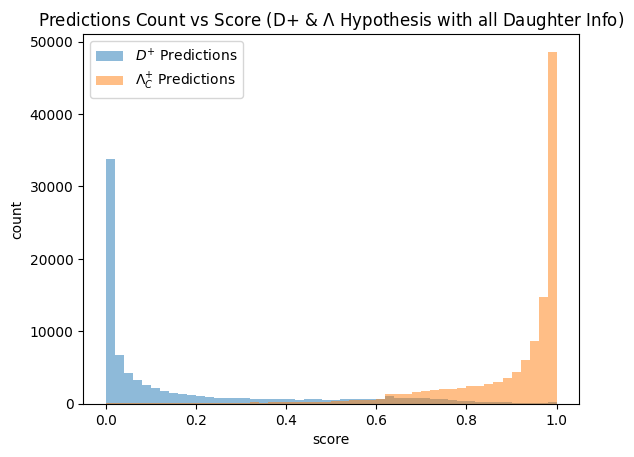

In [133]:
hist = plt.hist(predictions_background, bins = 50, label = "$D^{+}$ Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Predictions Count vs Score (D+ & $\Lambda$ Hypothesis with all Daughter Info)")
plt.legend()
plt.show()

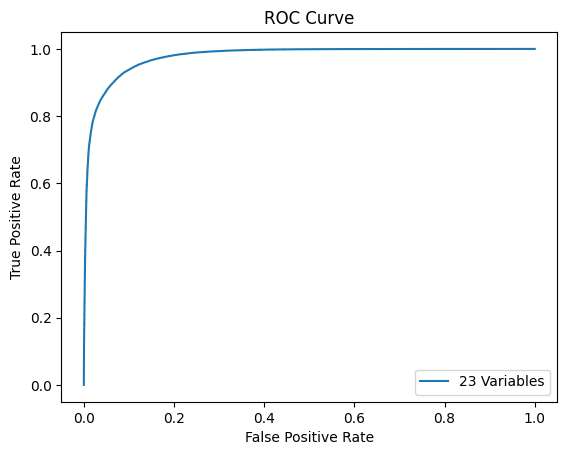

In [134]:
# Get true labels and predicted probabilities
y_true = list(y_test)
y_pred = predictions_both

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label = "{} Variables".format(len(training_columns)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()